In [1]:
%pylab inline
from io import BytesIO
import IPython.display
import hashlib
import struct

from svgpathtools import * 
import cmath

Populating the interactive namespace from numpy and matplotlib


In [2]:
paths, attributes = svg2paths('base.svg')
tops = []
for i in range(1, 4):
    ipaths, iattributes = svg2paths('1t%s.svg' % i)
    tops.append(ipaths)
bottoms = []
for i in range(1, 6):
    ipaths, iattributes = svg2paths('1b%s.svg' % i)
    bottoms.append(ipaths)
    


In [5]:
def displaysvg(*arg, **kw):
    if "filename" not in kw:
        kw["filename"]="test.svg"
    wsvg(*arg, **kw)
    with open(kw["filename"], "rb") as f:
        data = f.read()
    IPython.display.display(IPython.display.SVG(data=data))


In [111]:
def _intersectionsort(i):
    ((T1, seg1, t1), (T2, seg2, t2)) = i
    return T2
def sort_intersections(intersections):
    return sorted(intersections, key=_intersectionsort)

def collapse_close_intersections(intersections):
    intersections = sort_intersections(intersections)
    out = []
    for i in range(0, len(intersections)):
        if out and misctools.isclose(out[-1][1][0], intersections[i][1][0]):
            continue
        out.append(intersections[i])
    return out

def slices(segments):
    """Returns list of slices through a path. Each slice is defined by two points on the path, where a line connects.
       Returns list of intersectionpairs:
       (((Tpath1, segpath1, tpath1), (Tline1, segline1, tline1)),
        ((Tpath2, segpath2, tpath2), (Tline2, segline2, tline2)))
    """
    b = segments.bbox()
    size = math.sqrt((b[1]-b[0])**2+(b[3]-b[2])**2)

    normals = [Line(s.point(i)-s.normal(i)*1e-15, s.point(i)+size*s.normal(i))
               for s in segments
               for i in linspace(1e-20, 1, 4)[:-1]]

    # Normals are not defined at t = 0 and t=1!!! Hack around...
    intersections = [(collapse_close_intersections(segments.intersect(normal)), normal) for normal in normals]
    groupedintersectionpairs = [[(intersectionline[0], intersectionline[1], normal)]
                                for intersectionline, normal in intersections
                                if len(intersectionline) >= 2]    
    
    return [intersectionpair
            for group in groupedintersectionpairs
            for intersectionpair in group]

def centerpoints(segments):

    """Calculates a list of center points inside a shape as well as a
       likeliehood for each point of being at the end of the shape (a
       corner). Returns list of:
       (distance, intersectionpair, centerpoint_coord)
       where distance is in ]0,1[, and close to 0 means corner
    """
    intersectionpairs = slices(segments)
    
    def distance(a, b):
        return math.sqrt((sin(a*2*pi) - sin(b*2*pi))**2 + (cos(a*2*pi) - cos(b*2*pi))**2)/2

    intersectionpairswithdistance = sorted([(distance(intersectionpair[0][0][0], intersectionpair[1][0][0]), intersectionpair)
                                            for intersectionpair in intersectionpairs],
                                           key=lambda p: p[0])

    centerpoints = [(distance,
                     intersectionpair,
                     (segments.point(intersectionpair[0][0][0])
                      + segments.point(intersectionpair[1][0][0])) / 2)
                    for distance, intersectionpair in intersectionpairswithdistance]

    full = Path(*segments)
    if not full.isclosed():
        full.append(Line(full.end, full.start))

    b = segments.bbox()

    return [(d, i, p) for (d, i, p) in centerpoints
            if path.path_encloses_pt(p, b[0]+1j*b[2]-1-1j, full)]


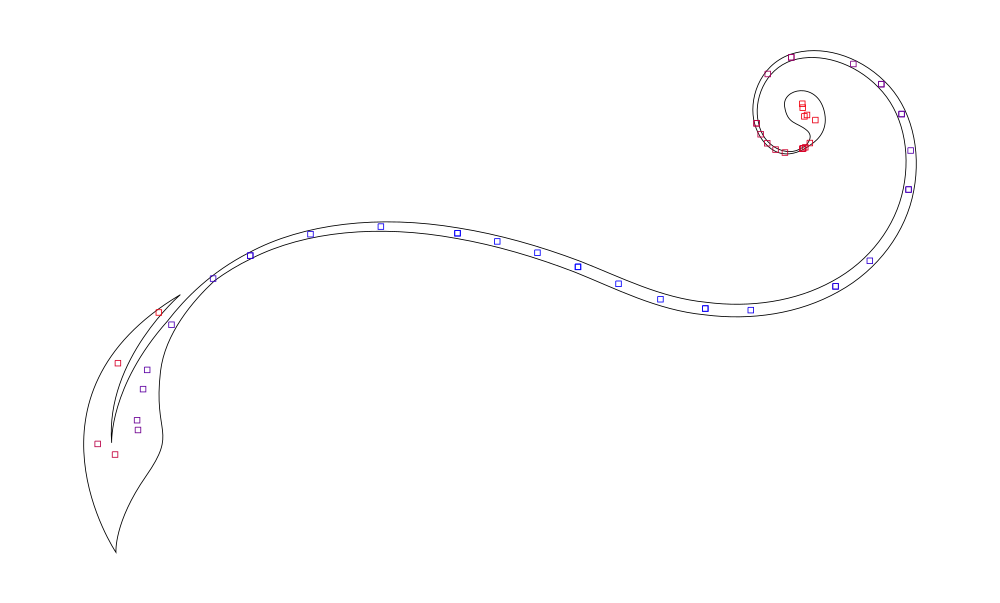

In [112]:
points = centerpoints(paths[0])

filtered = []
for entry in sorted(points, key=lambda entry: entry[2].real):
    if filtered and misctools.isclose(filtered[-1][2], entry[2]):
        continue
    filtered.append(entry)
points = filtered
    

def marker(point, size=1):
    return path.bbox2path(point.real-size, point.real+size, point.imag-size, point.imag+size)


def line(intersectionpair):
    return Line(paths[0].point(intersectionpair[0][0][0]),
                paths[0].point(intersectionpair[1][0][0]))

linepoints = [marker(paths[0].point(intersectionpair[i][0][0]))
              for d, intersectionpair, p in points
                     for i in (0, 1)]
linepoints_c = [(0,128,0) for i in linepoints]

lpoints =  [marker(p) for d, i, p in points]
lpoints_c = [(255-int(255*d),0,int(255*d)) for d, i, p in points]

lines = [line(i) for d, i, p in points]
lines_c = [(255-int(255*d),0,int(255*d)) for d, i, p in points]
lines_c = [(255,0,0) for d, i, p in points]

normals = [i[2] for d, i, p in points]
normals_c = [(0,0,128) for intersectionpair in points]

out = [paths[0]] + lpoints
colors = [(0,0,0)] +  lpoints_c

displaysvg(out, colors=colors, mindim=1000)


In [113]:
dmean = numpy.array([d for d, i, p in points]).mean()
dstd = numpy.array([d for d, i, p in points]).std()

orderedcenterpoints = sorted(
    [(i[0][0][0], d, i, p) for d, i, p in points]
    + [(i[1][0][0], d, i, p) for d, i, p in points],
    key = lambda a: a[0])

clusters = []
cluster = []
for T, d, i, p in orderedcenterpoints:
    if d > dmean - dstd:
        if cluster:
            clusters.append(cluster)
            cluster = []
    else:
        cluster.append((T, d, i, p))
if cluster:
    clusters.append(cluster)
    cluster = []

clusters = sorted([numpy.array([T for T, d, i, p in cluster]).mean() for cluster in clusters])
first = clusters[0]
last = clusters[1]
if last - first < .5:
    first, last = last, first


In [114]:
if first < last:
    orderedcenterpointsnocopies = [(L, d, i, p) for (L, d, i, p) in orderedcenterpoints
                                   if L >= first and L <=last]
else:
    orderedcenterpointsnocopies = ([(L, d, i, p)
                                    for (L, d, i, p) in orderedcenterpoints
                                    if L >= first] +
                                   [(L, d, i, p)
                                    for (L, d, i, p) in orderedcenterpoints
                                    if L <= last])


In [109]:
len(orderedcenterpointsnocopies), len(points)

(46, 45)

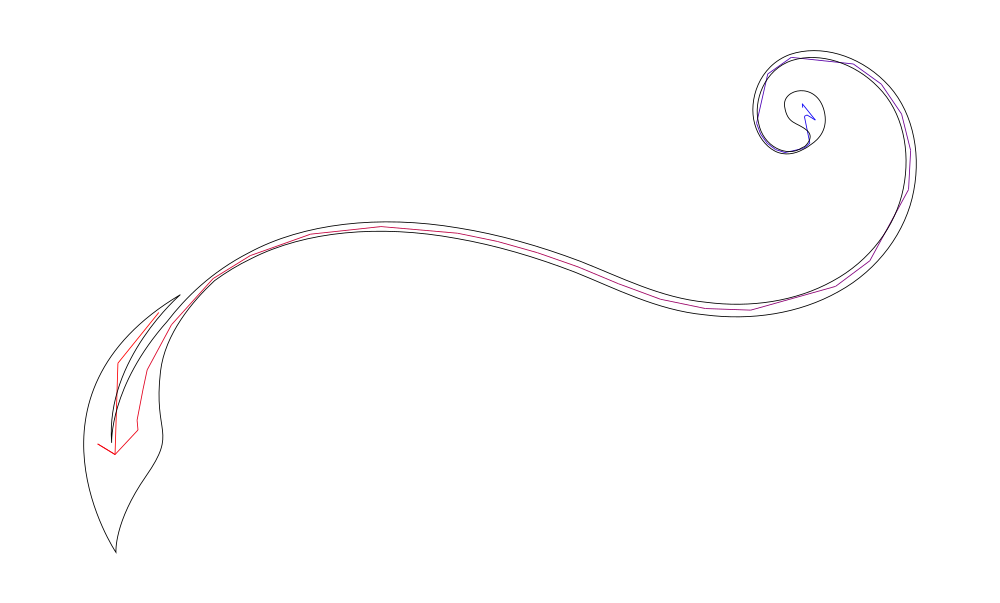

In [115]:

lines = [Line(orderedcenterpointsnocopies[i][3], orderedcenterpointsnocopies[i-1][3])
         for i in range(1, len(orderedcenterpointsnocopies))]
out = lines + [paths[0]]
colors = [(255-int(255 * i / len(lines)),0,int(255 * i / len(lines))) for i in range(len(lines))] + [(0,0,0)]

wsvg(out, colors=colors, mindim=1000, filename="test.svg")
with open("test.svg", "rb") as f:
    data = f.read()
IPython.display.display(IPython.display.SVG(data=data))

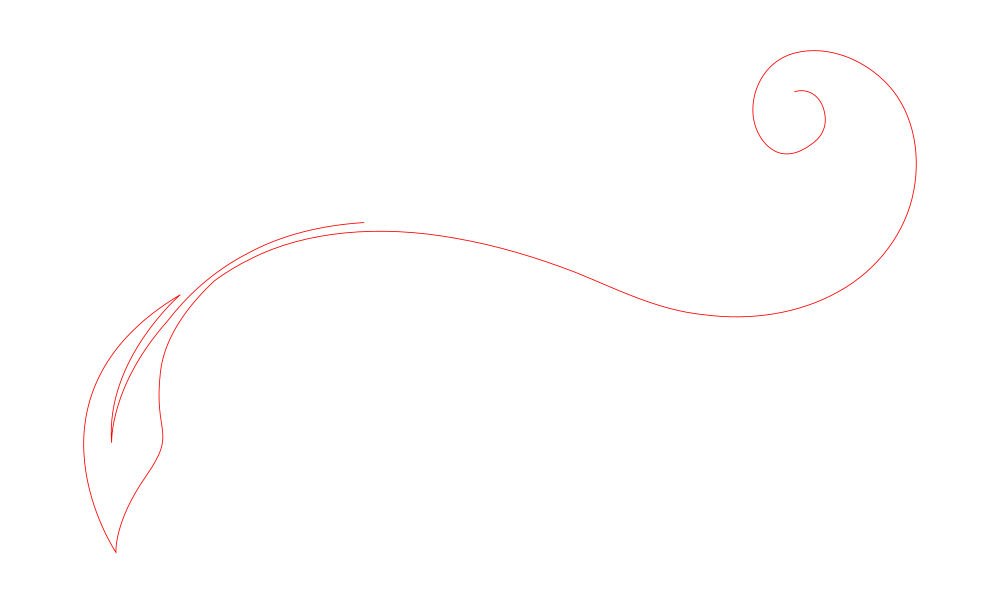

In [592]:
p = Path(*paths[0])
p.append(Line(p.end, p.start))
out = [p.cropped(first, last)]
colors = [(255,0,0)]

wsvg(out, colors=colors, mindim=1000, filename="test.svg")
with open("test.svg", "rb") as f:
    data = f.read()
IPython.display.display(IPython.display.SVG(data=data))

In [208]:
# from https://medium.com/@francoisromain/smooth-a-svg-path-with-cubic-bezier-curves-e37b49d46c74

In [361]:
points = [p[3] for p in orderedcenterpointsnocopies]

In [117]:
import approximate_bezier

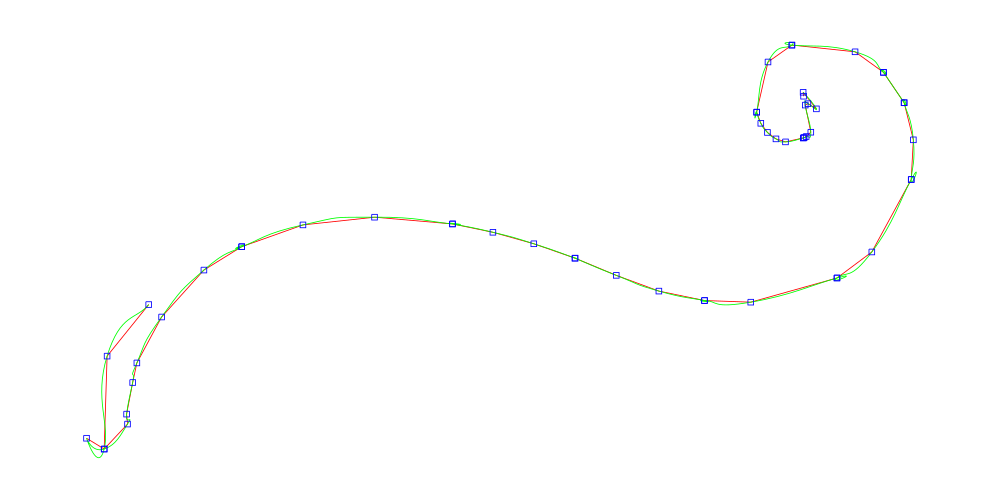

In [120]:
points2 = [p[3] for p in orderedcenterpointsnocopies]

curve = approximate_bezier.approximate_bezier(points2, smoothing=.3)

lines = Path(*[Line(points2[i], points2[i-1])
               for i in range(1, len(points2))])

out = [lines, curve]  + [marker(p) for p in points2]
colors = [(255,0,0), (0,255,0)] + [(0, 0, 255) for p in points2]

wsvg(out, colors=colors, mindim=1000, filename="test.svg")
with open("test.svg", "rb") as f:
    data = f.read()
IPython.display.display(IPython.display.SVG(data=data))

In [444]:
len(points)

11

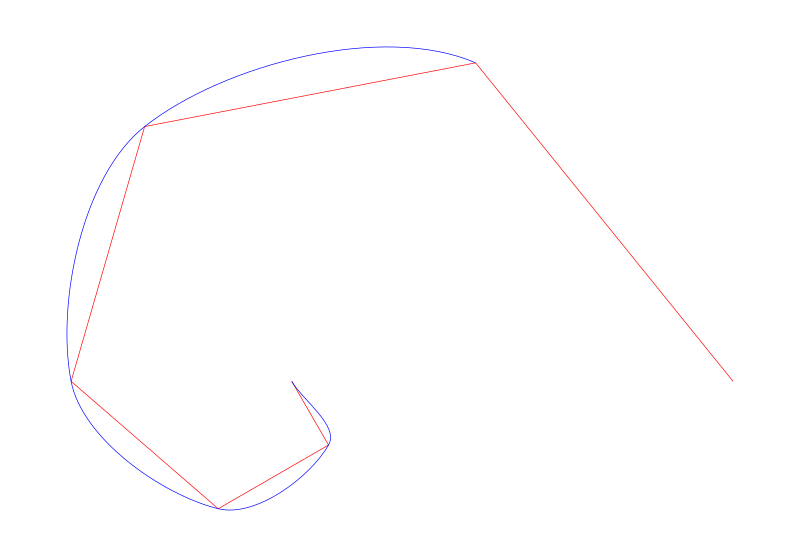

In [426]:
points = [a * (cos(a)+1j*sin(a)) for a in linspace(0, 2*pi, 7)]
centercurve = approximate_bezier.approximate_bezier(points, smoothing=.3)

lines = Path(*[Line(points[i], points[i-1])
               for i in range(1, len(points))])

out = [lines, centercurve]
colors = [(255,0,0), (0,0,255)]

wsvg(out, colors=colors, mindim=800, filename="test.svg")
with open("test.svg", "rb") as f:
    data = f.read()
IPython.display.display(IPython.display.SVG(data=data))

In [572]:
import importlib
importlib.reload(approximate_bezier)

<module 'approximate_bezier' from '/home/redhog/Projects/beta/InfiniteGlass/Patternplay/approximate_bezier.py'>

In [100]:
misctools.isclose(1e-15+1e-15j, 0)

True

In [99]:
5e-2j == 1j * 5e-2

True